# Importul Librariilor

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

#### Importam librariile de care vom avea nevoie:

In [149]:
import pandas as pd
import seaborn as sns
import os
import numpy as np
import sys
import matplotlib.pyplot as plt
import sklearn
import missingno as msno
from sklearn.svm import SVC
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, accuracy_score, confusion_matrix, roc_curve
from scipy.stats import stats, zscore, pearsonr, uniform
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold, StratifiedKFold, RandomizedSearchCV
import seaborn as sns
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA


pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

# Importul seturilor de date

#### Fiecare fisier de tip .tsv reprezinta o matrice functionala de corelatie a conectomilor din creierul unui singur individ. Aceste fisiere contin, deci, sute de valori, fiecare trebuind sa fie importat in baza de date drept o variabila, fiecare variabila fiind, apoi, adaugata intr-o lista.
#### Fiind matrici de corelatie, pentru a lua valorile unice si a nu le repeta, vor trebui luate doar elementele din triunghiul superior al matricei, fara diagonala principala (intrucat aceasta contine doar corelatiile intre un element si el insusi, adica valoarea "1".

In [92]:
def convert_matrix_to_long_row(matrix):

    if isinstance(matrix, np.ndarray):
        matrix = pd.DataFrame(matrix)

    # Get upper triangle of the matrix (excluding the diagonal)
    upper_triangle = matrix.where(np.triu(np.ones(matrix.shape), k=1).astype(bool))

    # Drop NaN values and get unique values
    unique_correlations = upper_triangle.stack().dropna().unique()

    return pd.DataFrame(unique_correlations).T

In [93]:
def generate_column_headers(matrix):
    rows, cols = matrix.shape
    headers = [f'{i}throw_{j}thcolumn' for i in range(rows) for j in range(cols) if i < j]
    return headers

#### Odata izolate fiecare dintre corelatii, acestea trebuie introduse in setul de date, alaturi de celelalte variabile. Functia urmatoare face acest lucru:

In [94]:
long_rows = []
all_headers = []

def process_folder(source_folder, output_file):
  long_rows = []
  # Iterate over items in the source folder

  for filename in os.listdir(source_folder):
      file_path = os.path.join(source_folder, filename)
      # print(filename)

      # edge cases: check if id is 12 bytes or 11
      len_id = 12 # default
      if filename[4:4+len_id][-1] == "_":
        print(filename[4:4+len_id])
        len_id = 11

      # Check if it is a file (and not a directory) and ends with .tsv
      if os.path.isfile(file_path) and filename.endswith('.tsv'):
          try:
              # Load the matrix
              matrix = pd.read_csv(file_path, sep='\t', header=None)

              # Generate column headers for this matrix
              headers = ['participant_id']+generate_column_headers(matrix)
              all_headers = headers  # Assume all files have the same matrix shape

              # Convert the matrix to a long row of unique correlations
              long_row = convert_matrix_to_long_row(matrix)

              # add patient ID
              extracted_id = filename[4:4+len_id]

              long_row.insert(0, "participant_id", extracted_id)

              # Append the long row as a new row in the results
              long_rows.append(long_row)

          except Exception as e:
              print(f"Error processing file {filename}: {e}")
      else:
          print(f"Skipping {filename} (not a file or not a TSV)")

  # need to write out the file
  out_df = pd.concat(long_rows)
  out_df.columns = headers
  out_df.to_csv(output_file, sep='\t', header=True)
  return out_df

#### Procedeu de import al datelor in notebook-ul integrat din platforma Kaggle:

In [95]:
source_folder_test = '/kaggle/input/wids-datathon-2025-ase-data-wizards/test_tsv/test_tsv'
output_file_test = '/kaggle/working/test_correlations.tsv'

source_folder_train = '/kaggle/input/wids-datathon-2025-ase-data-wizards/train_tsv/train_tsv'
output_file_train = '/kaggle/working/train_correlations.tsv'

In [96]:
test_big = process_folder(source_folder_test, output_file_test)
train_big = process_folder(source_folder_train, output_file_train)

NDARJ257ZU2_
NDARVB04TJA_


In [97]:
# checking lengths of the train/test big dataframes to make sure there were no errors in uploads/processing

# should be: 1104 rows
print("# rows, train: ", len(train_big))
# should be: 474 rows
print("# rows, test: ", len(test_big))

# rows, train:  1104
# rows, test:  474


#### Odata create seturile de date cu corelatie, acestea trebuie unite cu celelalte variabile, care se regasesc in fisierele cu metadata.

In [98]:
test_short=pd.read_csv('/kaggle/input/wids-datathon-2025-ase-data-wizards/metadata/test_metadata.csv')
train_short=pd.read_csv('/kaggle/input/wids-datathon-2025-ase-data-wizards/metadata/training_metadata.csv')

In [99]:
# Checking the size of our short datframes

print(train_short.shape)
# Out[160]: (1104, 4)

print(test_short.shape)
# Out[161]: (474, 4)

(1104, 14)
(474, 13)


#### Se unesc cele doua sub-seturi de date pentru a crea seturile initiale de date, cu care putem merge mai departe in analiza.

In [100]:
train = pd.merge(train_big, train_short, on='participant_id', how='outer')

test = pd.merge(test_big, test_short, on='participant_id', how='outer')

In [101]:
# print the first few rows of dataframe
print(train.head())
print(test.head())

# print the shape of dataframe
print(train.shape)
print(test.shape)

  participant_id  0throw_1thcolumn  0throw_2thcolumn  0throw_3thcolumn  \
0   NDAREU551GPC               0.3               0.8               0.7   
1   NDARLF032LXH               0.2               0.7               0.5   
2   NDARAY475AKD              -0.1               0.4               0.3   
3   NDARWV155PRG              -0.2               0.7               0.2   
4   NDARYK164AEJ               0.1               0.7               0.1   

   0throw_4thcolumn  0throw_5thcolumn  0throw_6thcolumn  0throw_7thcolumn  \
0               0.8               0.8               0.6               0.5   
1               0.6               0.7               0.6               0.8   
2               0.4               0.4               0.7               0.6   
3               0.5               0.9               0.7               0.6   
4               0.4               0.6               0.7               0.6   

   0throw_8thcolumn  0throw_9thcolumn  ...  bmi               ethnicity  \
0               0

## Valori Lipsa

#### Identificam cate valori lipsa exista in fiecare set de date:

In [102]:
#Check for NaN in the test dataframe
print("NaN values in test:", pd.isna(test).sum().sum())

#Check for NaN in the train dataframe
print("NaN values in train:", pd.isna(train).sum().sum())

NaN values in test: 230
NaN values in train: 1688


## Valori Categoriale si Numerice

#### Fiindca setul de date contine atat variabile cantitative, cat si calitative, pentru a gasi metode potrivite de imputare a valorilor lipsa, acestea trebuie separate. Astfel, celula urmatoare, odata rulata, creeaza liste cu numele variabilelor de fiecare tip:

In [103]:
# Separate numerical and categorical columns
numerical_cols = [col for col in train.columns if train[col].dtypes != 'object' and col != 'age']
categorical_cols = [col for col in train.columns if train[col].dtypes == 'object' and col != 'participant_id']

print(f'Numarul de variabile cantitative: {len(numerical_cols)} \n')

print('Urmatoarele variabile sunt calitative:')
for i in categorical_cols:
    print(i)


Numarul de variabile cantitative: 19905 

Urmatoarele variabile sunt calitative:
sex
study_site
ethnicity
race
handedness
parent_1_education
parent_2_education


#### S-au creat doua variabile: numerical_cols, respecit categorical_cols. Pentru a demonstra ca acestea merg apelate atat pentru setul de date train, cat si pentru test, dforim sa vedem daca exista diferente intre structurile celor doua seturi de date (exceptand, bineinteles, variabila tinta "age").

In [104]:
differences = set(train.columns) - set(test.columns)
differences

{'age'}

#### Dupa cum am intuit, singura diferenta dintre cele doua seturi de date este "age", care oricum reprezenta variabila target si va fi luata separat. Din asta putem extrage urmatoarele concluzii:
- Nu trebuie modificata structura niciuneia dintre cele doua baze de date;
- Putem imparti intre variabile numerice si categoriale. Putem aplica un singur algoritm si va functiona pentru ambele seturi de date. 

## Imputarea valorilor lipsa

### a) Variabile calitative

#### Inlocuim valorile lipsa cu "Unknown":

In [105]:
for col in categorical_cols:
    train[col] = train[col].fillna("Unknown")
    test[col] = test[col].fillna("Unknown")

### b) Variabile cantitative

#### Intrucat urmeaza sa vedem ca multe dintre variabile nu sunt simetric distribuite, imputarea cu media este departe de a reprezenta solutia optima pentru imputarea valorilor lipsa. De aceea, am decis sa folosim metoda K-Nearest Neighbours

In [106]:
imp = KNNImputer(n_neighbors=3)
train.loc[:, numerical_cols] = imp.fit_transform(train[numerical_cols])
test.loc[:, numerical_cols] = imp.transform(test[numerical_cols])

In [107]:
#Check for NaN in the test dataframe
print("NaN values in test:", pd.isna(test).sum().sum())

#Check for NaN in the train dataframe
print("NaN values in train:", pd.isna(train).sum().sum())

NaN values in test: 0
NaN values in train: 0


#### Nu mai avem valori lipsa!

## Vectorii de corelatie

#### Dupa cum este sugerat in descrierea concursului, vom realiza o noua coloana numita ['Correlation Vector'], ce va contine toate valorile coeficientilor de corelatie intre toti nodulii creierului unui individ, aranjate intr-o lista unica pentru fiecare individ. 

In [108]:
train['Correlation Vector'] = train.filter(like = 'row', axis = 1).values.tolist()
train['Correlation Vector']

0       [0.3269574432491515, 0.7710647120230391, 0.745...
1       [0.17090123035702923, 0.6918205349925542, 0.51...
2       [-0.13252538627152988, 0.39070253037434766, 0....
3       [-0.2365493453017804, 0.6735550159288215, 0.16...
4       [0.11425958806774462, 0.6649437874120495, 0.06...
                              ...                        
1099    [-0.07942348521180218, 0.803964010635741, 0.58...
1100    [0.2471984042207144, 0.48725924707988494, 0.39...
1101    [0.2523027185919816, 0.445674610740961, 0.5131...
1102    [-0.025806144160725953, 0.7347844672959493, 0....
1103    [0.5868541785111133, 0.813502287256733, 0.7590...
Name: Correlation Vector, Length: 1104, dtype: object

#### Odata creati vectorii, putem sterge coloanele ce contineau fiecare coeficient de corelatie in sine:

In [109]:
train.columns[train.columns.str.contains('row')]

Index(['0throw_1thcolumn', '0throw_2thcolumn', '0throw_3thcolumn',
       '0throw_4thcolumn', '0throw_5thcolumn', '0throw_6thcolumn',
       '0throw_7thcolumn', '0throw_8thcolumn', '0throw_9thcolumn',
       '0throw_10thcolumn',
       ...
       '195throw_196thcolumn', '195throw_197thcolumn', '195throw_198thcolumn',
       '195throw_199thcolumn', '196throw_197thcolumn', '196throw_198thcolumn',
       '196throw_199thcolumn', '197throw_198thcolumn', '197throw_199thcolumn',
       '198throw_199thcolumn'],
      dtype='object', length=19900)

In [110]:
train.drop(train.columns[train.columns.str.contains('row')], axis = 1, inplace = True)
train

,participant_id,age,sex,study_site,bmi,ethnicity,race,handedness,parent_1_education,parent_2_education,p_factor_fs,internalizing_fs,externalizing_fs,attention_fs,Correlation Vector
0,NDAREU551GPC,9.4,Female,HBNsiteRU,22.0,Not_Hispanic_or_Latino,White,Right,Complete_tertiary,Complete_tertiary,0.5,1.6,-0.0,-1.8,"[0.3269574432491515, 0.7710647120230391, 0.745..."
1,NDARLF032LXH,14.1,Male,HBNsiteRU,20.1,Not_Hispanic_or_Latino,Black,Left,Complete_secondary,No_incomplete primary,-0.9,0.1,-0.6,-0.2,"[0.17090123035702923, 0.6918205349925542, 0.51..."
2,NDARAY475AKD,7.3,Female,HBNsiteRU,13.6,Not_Hispanic_or_Latino,White,Right,Complete_tertiary,Complete_tertiary,-1.1,0.2,-0.5,-0.7,"[-0.13252538627152988, 0.39070253037434766, 0...."
3,NDARWV155PRG,15.8,Female,HBNsiteSI,22.2,Hispanic_or_Latino,Unknown,Right,Complete_primary,Complete_secondary,2.1,0.4,0.7,0.7,"[-0.2365493453017804, 0.6735550159288215, 0.16..."
4,NDARYK164AEJ,14.2,Male,HBNsiteCBIC,22.4,Unknown,White,Right,Complete_tertiary,Complete_tertiary,1.3,-1.2,-0.6,0.2,"[0.11425958806774462, 0.6649437874120495, 0.06..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099,NDARMK046ZRK,9.9,Female,HBNsiteCBIC,20.9,Hispanic_or_Latino,White,Right,Complete_tertiary,Complete_secondary,-0.0,0.8,-0.6,1.9,"[-0.07942348521180218, 0.803964010635741, 0.58..."
1100,NDAREV848HWX,11.6,Male,HBNsiteCBIC,19.9,Not_Hispanic_or_Latino,White,Right,Complete_tertiary,Complete_tertiary,0.0,0.5,-1.2,0.8,"[0.2471984042207144, 0.48725924707988494, 0.39..."
1101,NDARVU320XJZ,8.9,Male,HBNsiteCBIC,17.2,Hispanic_or_Latino,White,Right,Complete_tertiary,Complete_tertiary,1.2,0.4,-1.2,0.3,"[0.2523027185919816, 0.445674610740961, 0.5131..."
1102,NDARLJ148JH2,10.2,Male,HBNsiteRU,19.1,Not_Hispanic_or_Latino,White,Right,Complete_secondary,Complete_secondary,-0.6,1.0,-0.8,2.4,"[-0.025806144160725953, 0.7347844672959493, 0...."


#### Redefinim coloanele numerice

In [111]:
numerical_cols = [col for col in train.columns if train[col].dtypes != 'object' and col != 'age']

# Analiza Exploratorie

#### a) Variabila „Țintă”

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


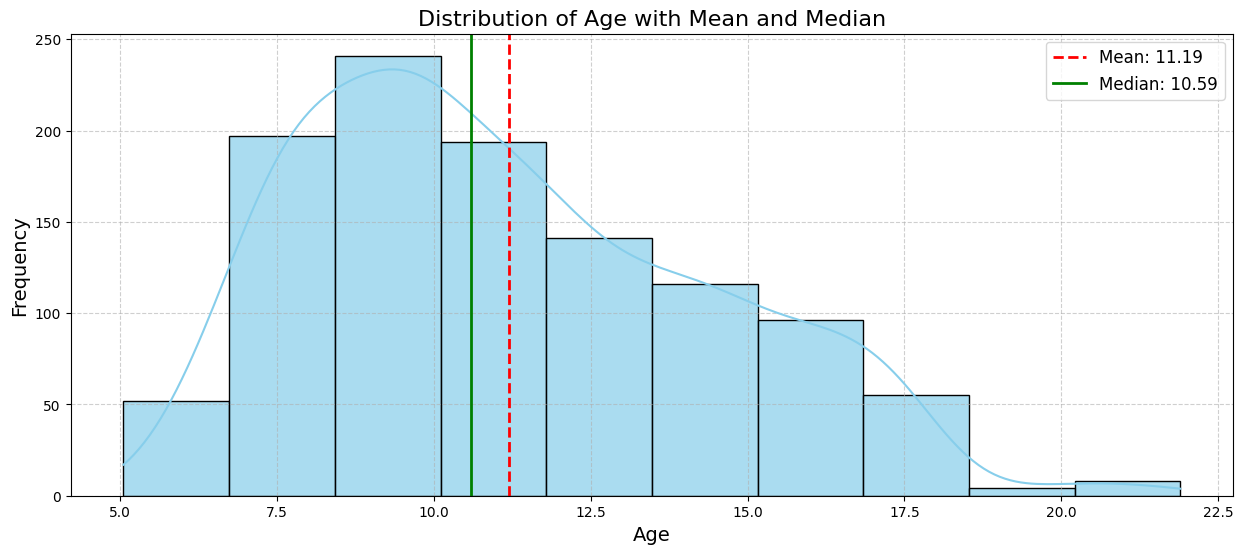

In [112]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate mean and median of the 'age' column
mean_age = train['age'].mean()
median_age = train['age'].median()

# Create the histogram with enhancements
fig, ax = plt.subplots(figsize=(15, 6))
sns.histplot(data=train, x='age', bins=10, kde=True, color='skyblue', edgecolor='black', alpha=0.7)

# Add vertical lines for mean and median
ax.axvline(mean_age, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_age:.2f}')
ax.axvline(median_age, color='green', linestyle='-', linewidth=2, label=f'Median: {median_age:.2f}')

# Add title, labels, and legend
ax.set_title('Distribution of Age with Mean and Median', fontsize=16)
ax.set_xlabel('Age', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.show()


#### Variabila tinta nu prezinta o distributie simetrica

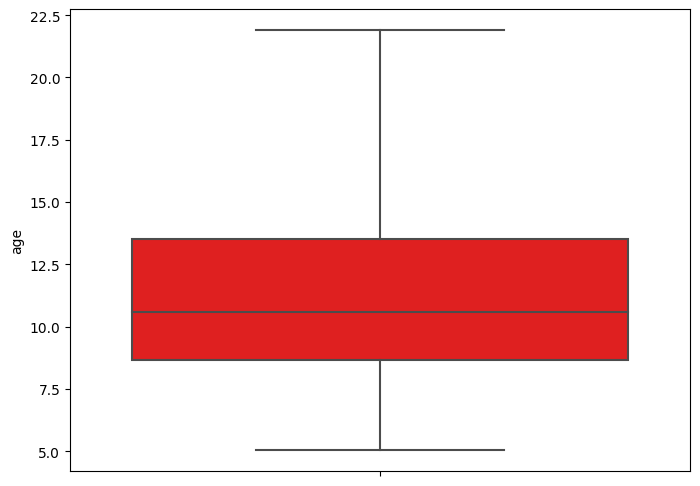

In [128]:
fig, ax = plt.subplots(figsize = (8,6))
sns.boxplot(y = train['age'], color = 'red', whis = 3)
plt.show()

#### Nu avem outlieri

### b) Train

In [113]:
removed_items = {'participant_id'}
filtered_categorical_cols = [i for i in categorical_cols if i not in removed_items]

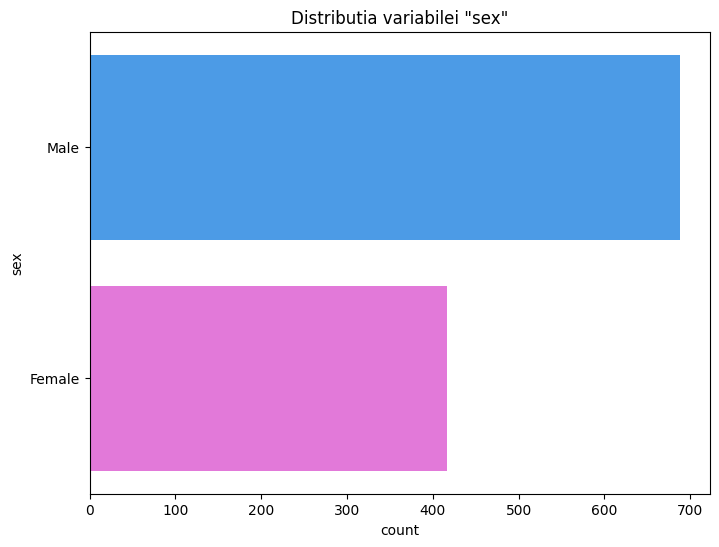

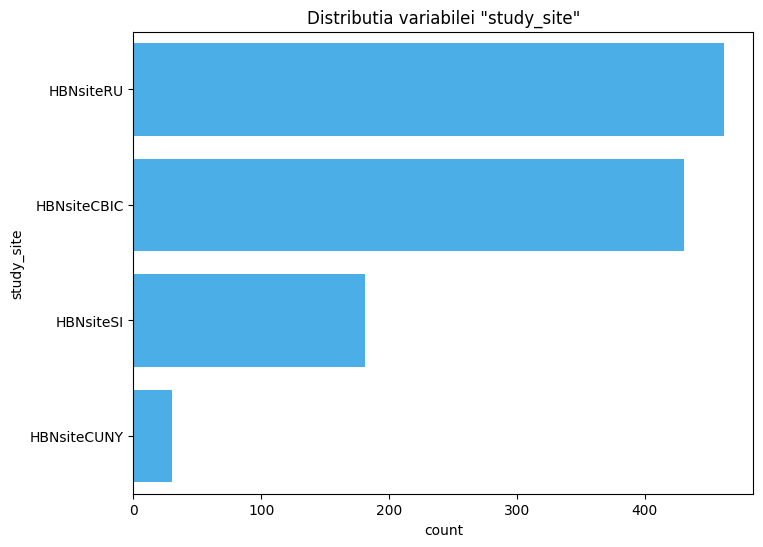

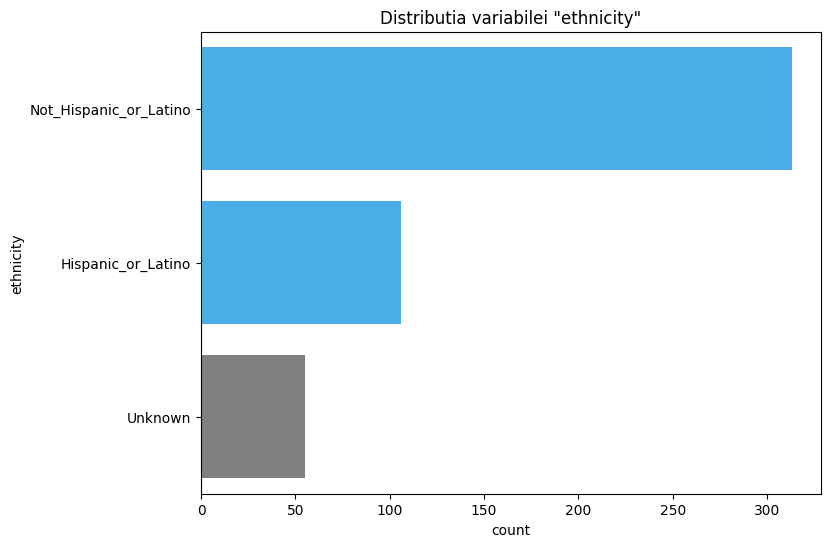

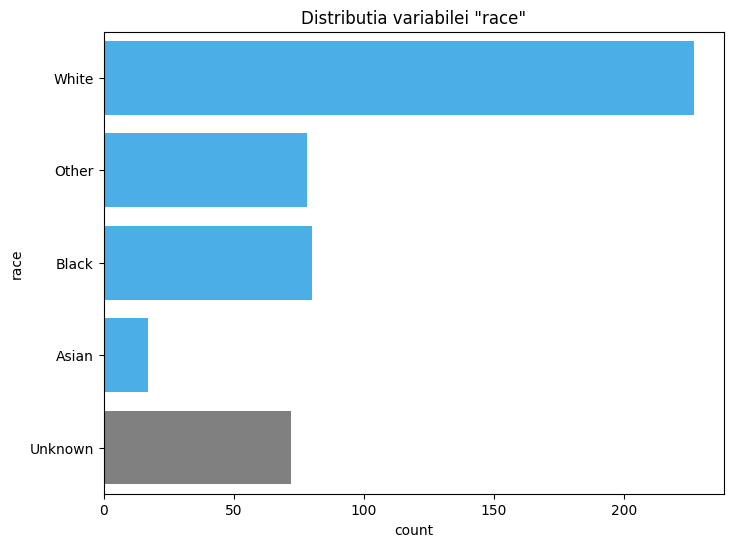

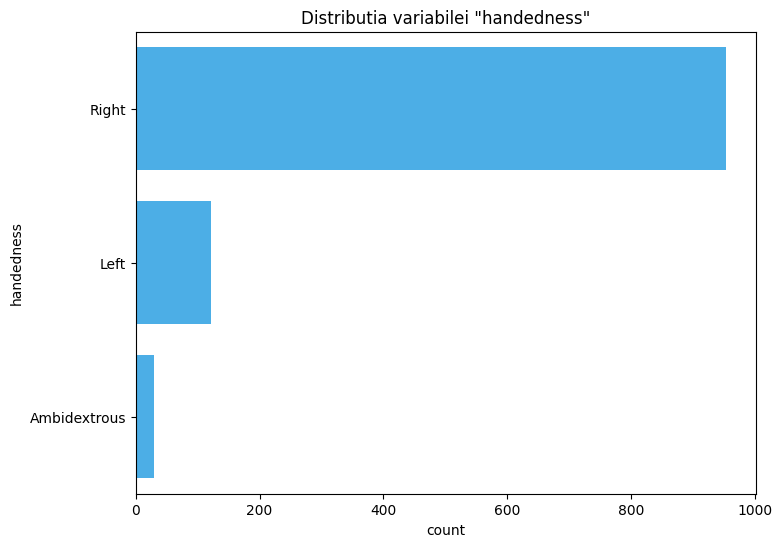

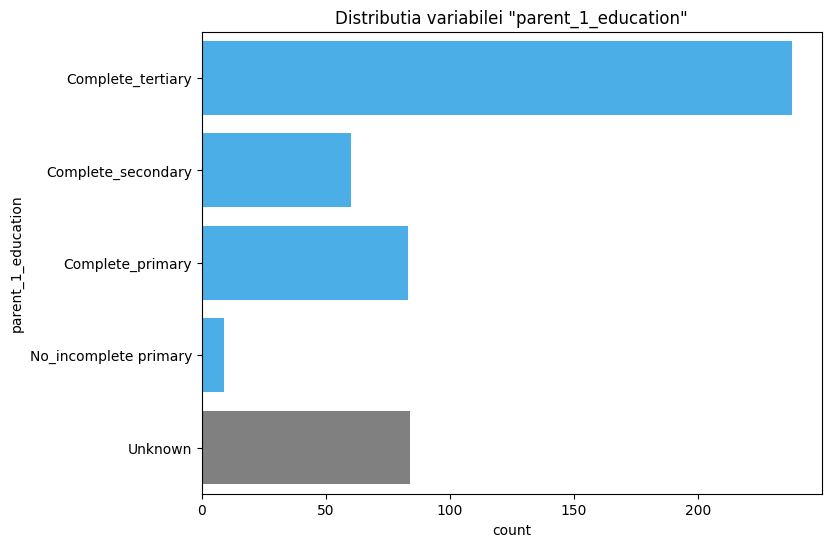

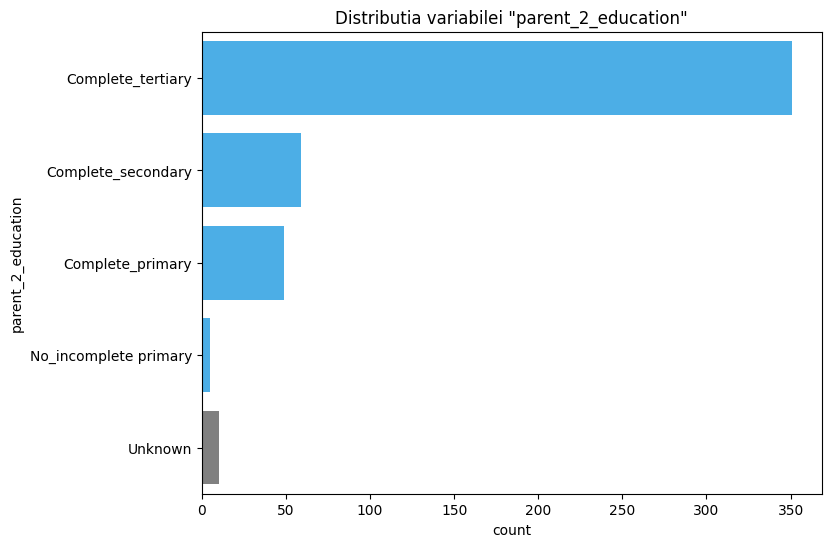

In [114]:
for col in categorical_cols:
    category_order = train[col].value_counts().index.tolist()
    custom_palette = {cat: ('gray' if cat == 'Unknown' else '#33b5ff') for cat in train[col].value_counts().index}
    fig, ax = plt.subplots(figsize = (8,6))
    if col == 'sex':
        gender_palette = {'Male':'#339cff','Female':'#f467e7'}
        ax = sns.countplot(data = train, y = col, order=category_order, palette = gender_palette)
    else:
        if 'Unknown' in category_order:
            category_order.remove('Unknown') 
            category_order.append('Unknown')  
            if col in ['parent_1_education','parent_2_education']:
                custom_order = ['Complete_tertiary','Complete_secondary','Complete_primary','No_incomplete primary','Unknown']
                ax = sns.countplot(data = test, y = col, order=custom_order, palette = custom_palette)
            else:    
                ax = sns.countplot(data = test, y = col, order=category_order, palette = custom_palette)
        else: 
            ax = sns.countplot(data = train, y = col, order = train[col].value_counts().index, color = '#33b5ff')
    ax.set_title(f'Distributia variabilei "{col}"')
    plt.show()

#### Observam ca:
- #### Graficele sunt aranjate in ordinea descrescatoare a marimii barelor (cu doua exceptii)
- #### Culorile din graficul "Distributia variabilei sex" sunt aferente celor doua genuri prezente in setul de date
- #### Pentru fiecare graifc unde exista categoria "Unknown", aceasta a fost mutata la final si colorata cu gri
- #### La graficele ce ilustreaza nivelul de educatie al parintilor, categoriile sunt ordonate in functie de ordinea cronologica a reusitelor academice

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

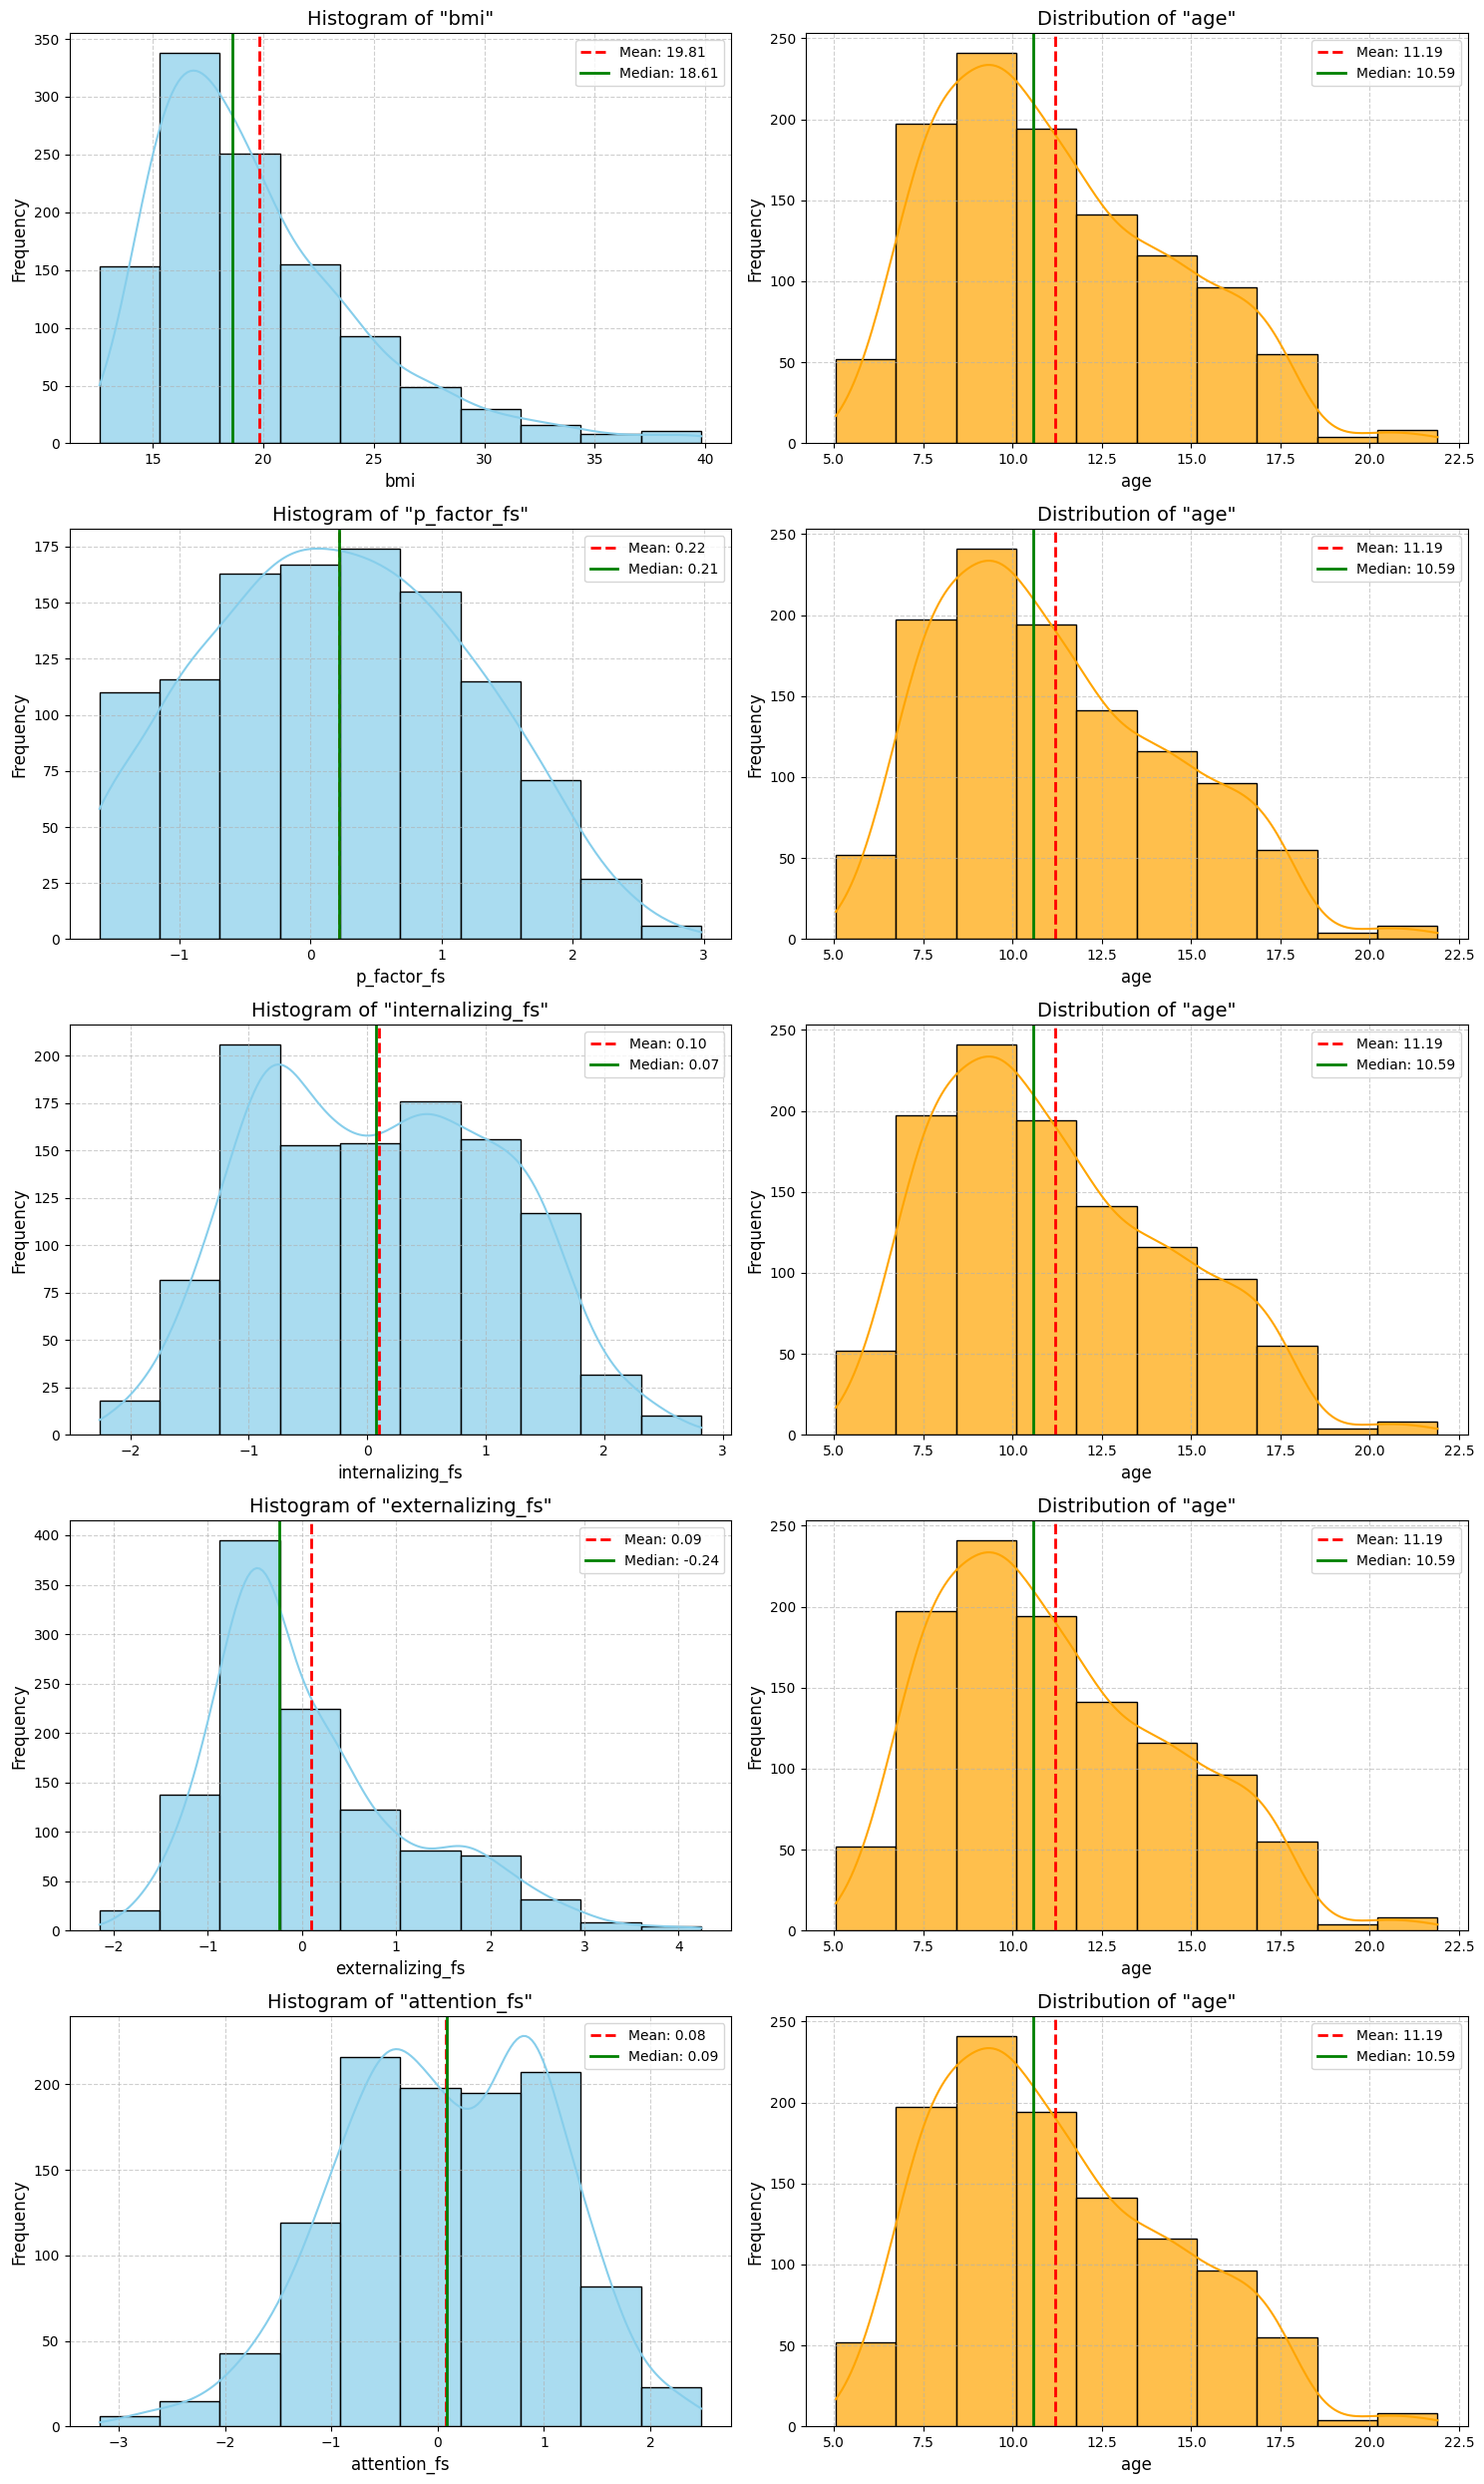

In [129]:
# Create subplots with 2 columns (one for each column, one for 'age')
n_rows = len(numerical_cols)
fig, axes = plt.subplots(n_rows, 2, figsize=(15, 5 * n_rows))  # Adjust figure size for readability

# Iterate over numerical columns
for i, col in enumerate(numerical_cols):
    # Plot the histogram for the current column
    mean_val = train[col].mean()
    median_val = train[col].median()
    sns.histplot(data=train, x=col, bins=10, kde=True, color='skyblue', edgecolor='black', alpha=0.7, ax=axes[i, 0])
    axes[i, 0].axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
    axes[i, 0].axvline(median_val, color='green', linestyle='-', linewidth=2, label=f'Median: {median_val:.2f}')
    axes[i, 0].set_title(f'Histogram of "{col}"', fontsize=14)
    axes[i, 0].set_xlabel(col, fontsize=12)
    axes[i, 0].set_ylabel('Frequency', fontsize=12)
    axes[i, 0].legend(fontsize=10)
    axes[i, 0].grid(True, linestyle='--', alpha=0.6)
    
    # Plot the distribution of 'age'
    mean_age = train['age'].mean()
    median_age = train['age'].median()
    sns.histplot(data=train, x='age', bins=10, kde=True, color='orange', edgecolor='black', alpha=0.7, ax=axes[i, 1])
    axes[i, 1].axvline(mean_age, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_age:.2f}')
    axes[i, 1].axvline(median_age, color='green', linestyle='-', linewidth=2, label=f'Median: {median_age:.2f}')
    axes[i, 1].set_title('Distribution of "age"', fontsize=14)
    axes[i, 1].set_xlabel('age', fontsize=12)
    axes[i, 1].set_ylabel('Frequency', fontsize=12)
    axes[i, 1].legend(fontsize=10)
    axes[i, 1].grid(True, linestyle='--', alpha=0.6)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


#### Nicio variabila nu este distribuita perfect simetric, dar variabila 'bmi'in special pare sa aiba valori outlier. Verificam boxplot-urile pentru fiecare variabila:

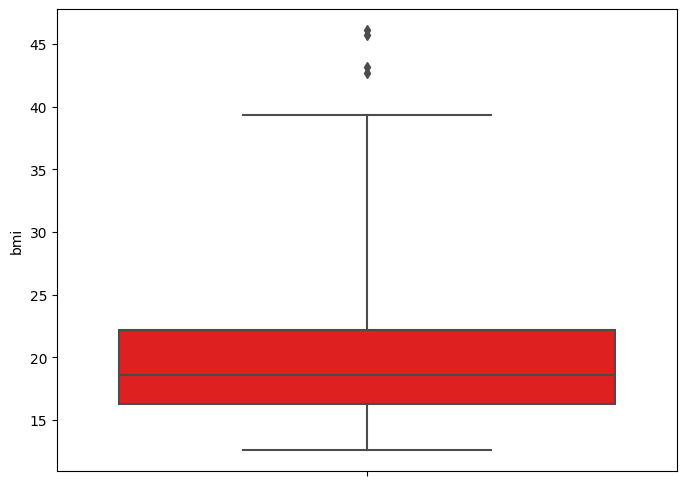

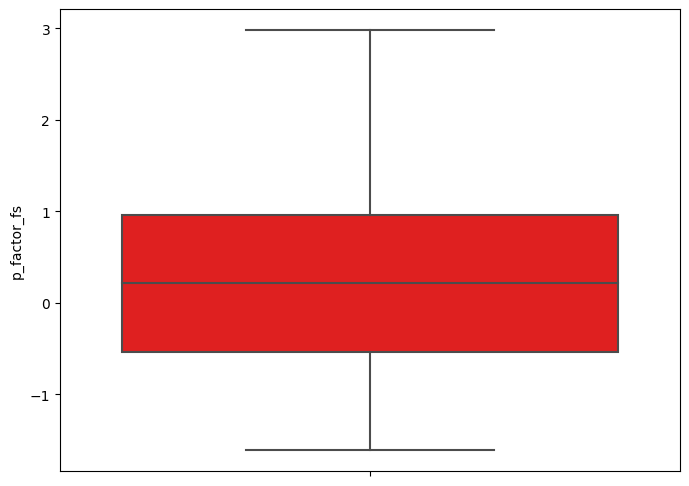

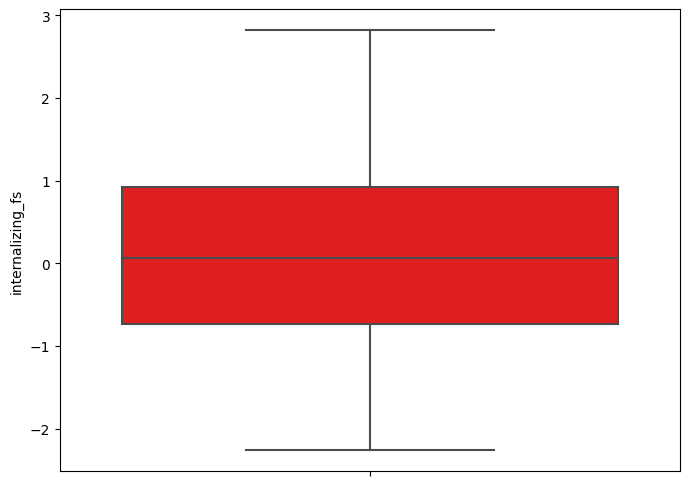

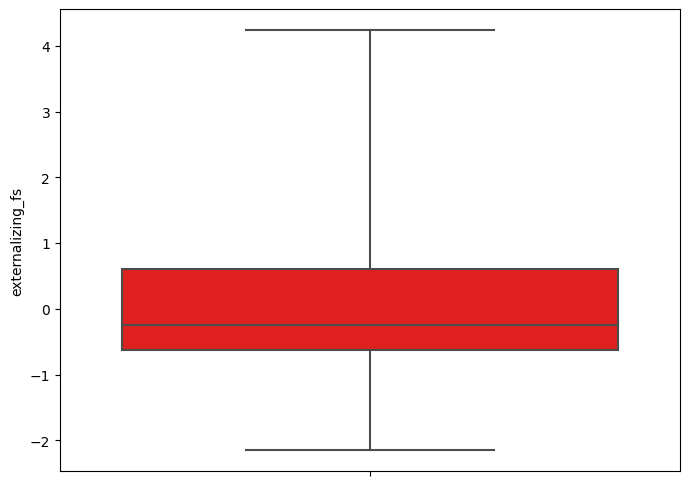

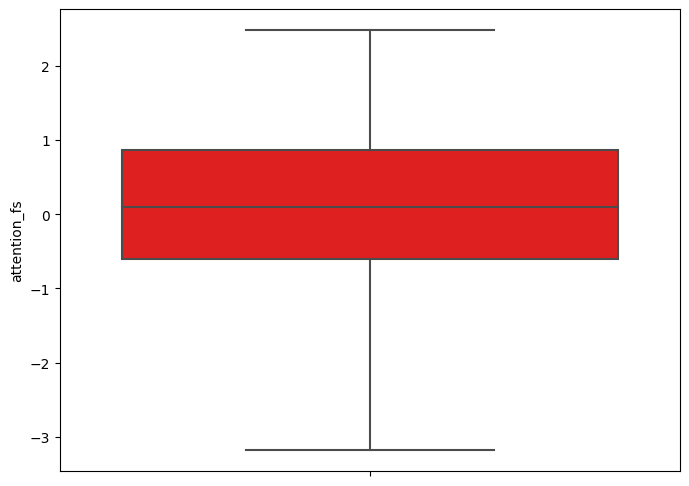

In [116]:
for col in numerical_cols:
    fig, ax = plt.subplots(figsize = (8,6))
    sns.boxplot(y = train[col], color = 'red', whis = 3)
    plt.show()

#### Intr-adeva, variabila 'bmi' are outlieri.

### c) Testing dataset

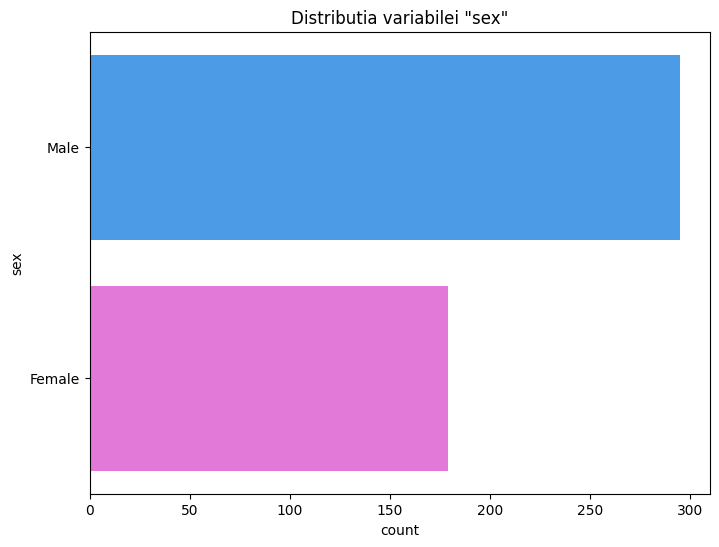

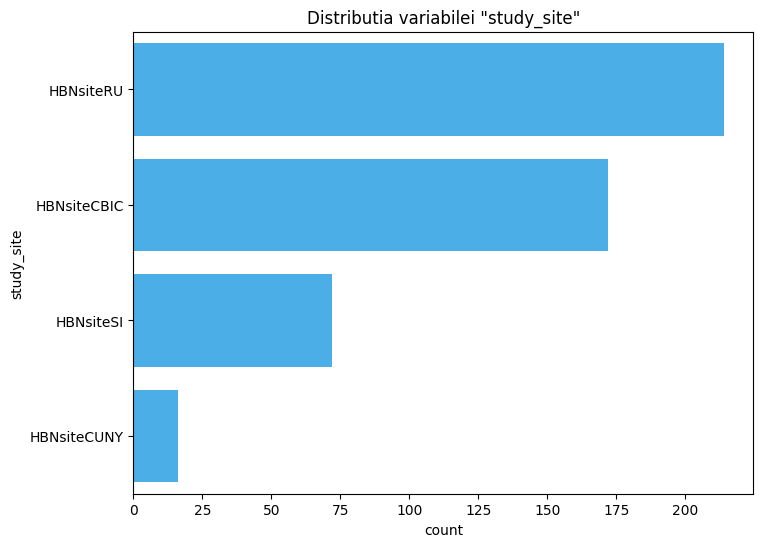

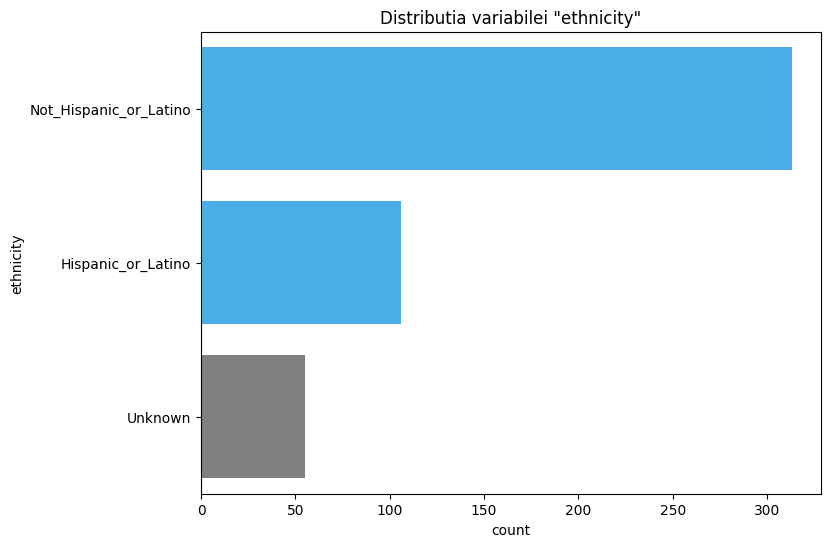

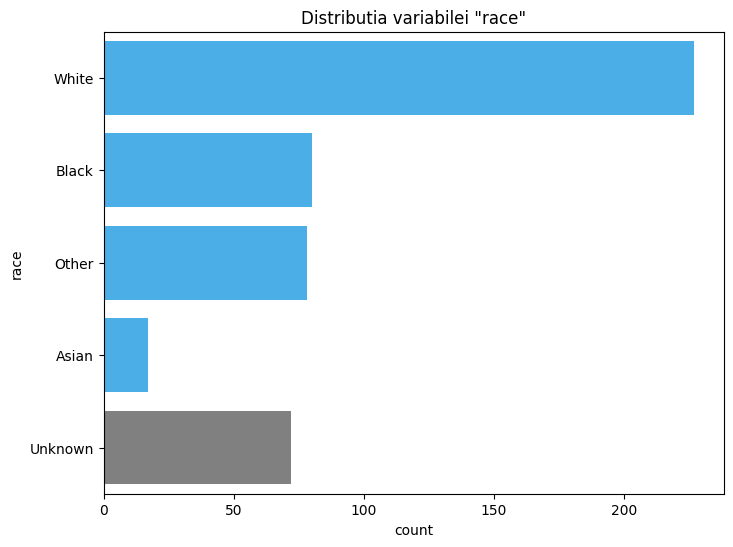

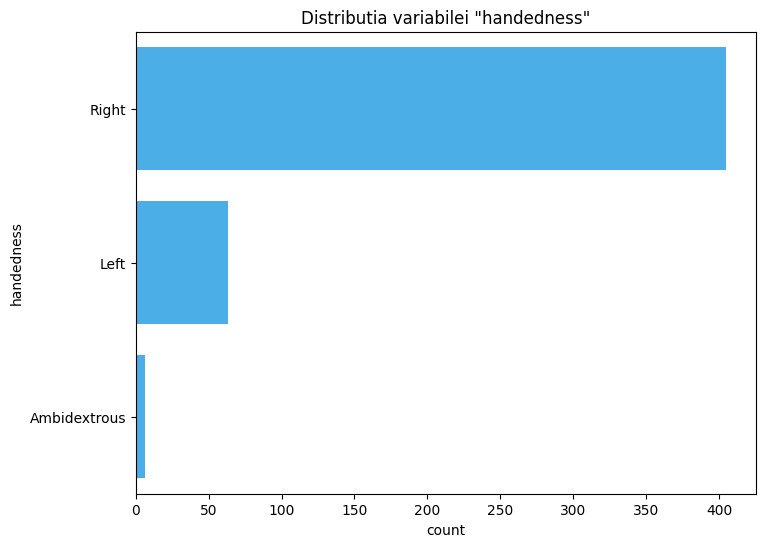

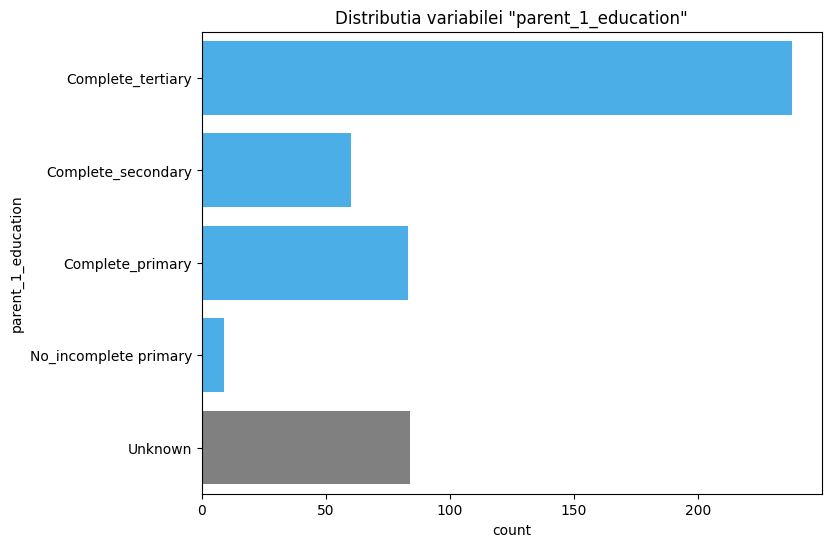

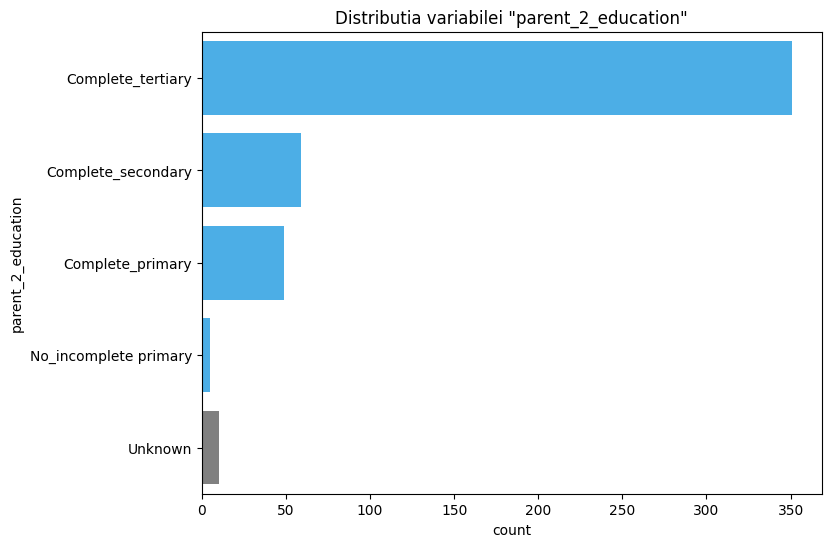

In [117]:
for col in categorical_cols:
    category_order = test[col].value_counts().index.tolist()
    custom_palette = {cat: ('gray' if cat == 'Unknown' else '#33b5ff') for cat in test[col].value_counts().index}
    fig, ax = plt.subplots(figsize = (8,6))
    if col == 'sex':
        gender_palette = {'Male':'#339cff','Female':'#f467e7'}
        ax = sns.countplot(data = test, y = col, order=category_order, palette = gender_palette)
    else:
        if 'Unknown' in category_order:
            category_order.remove('Unknown') 
            category_order.append('Unknown')
            if col in ['parent_1_education','parent_2_education']:
                custom_order = ['Complete_tertiary','Complete_secondary','Complete_primary','No_incomplete primary','Unknown']
                ax = sns.countplot(data = test, y = col, order=custom_order, palette = custom_palette)
            else:    
                ax = sns.countplot(data = test, y = col, order=category_order, palette = custom_palette)
        else: 
            ax = sns.countplot(data = test, y = col, order = test[col].value_counts().index, color = '#33b5ff')
    ax.set_title(f'Distributia variabilei "{col}"')
    plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


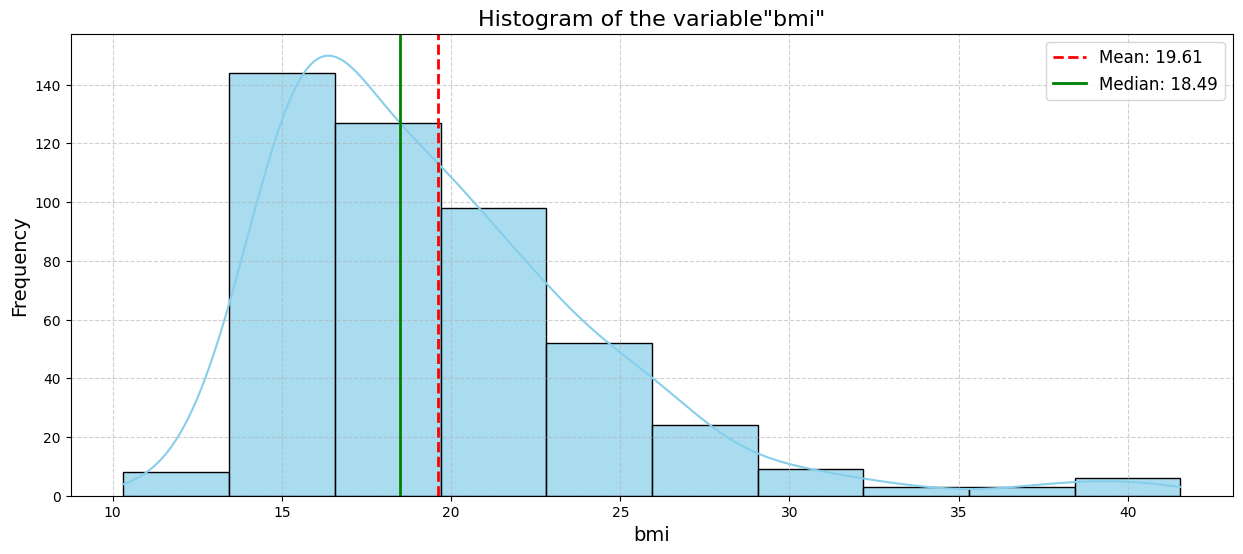

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


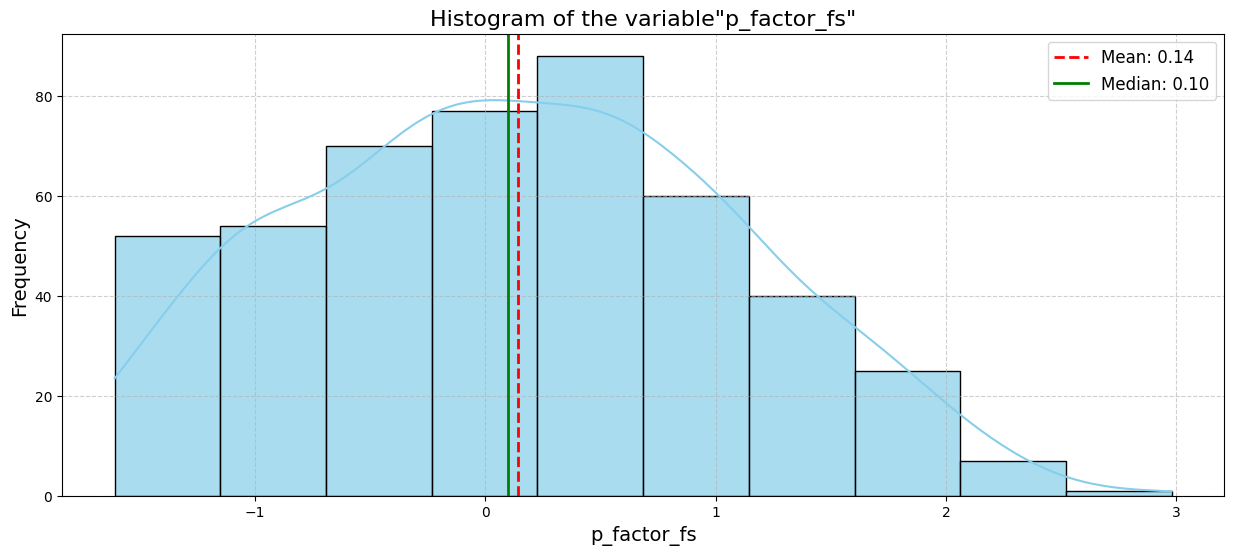

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


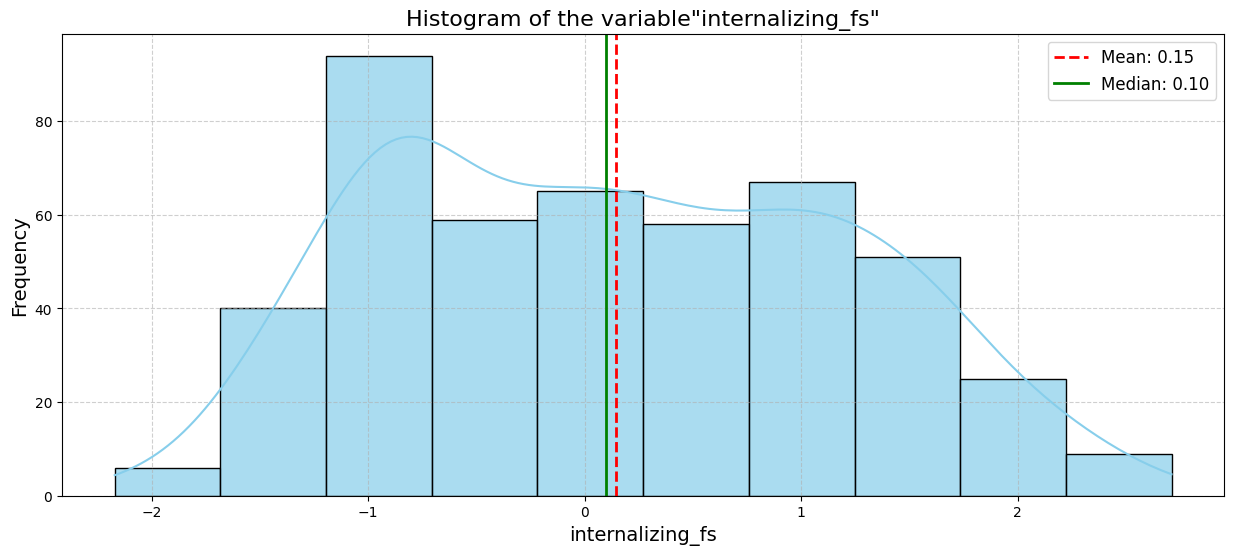

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


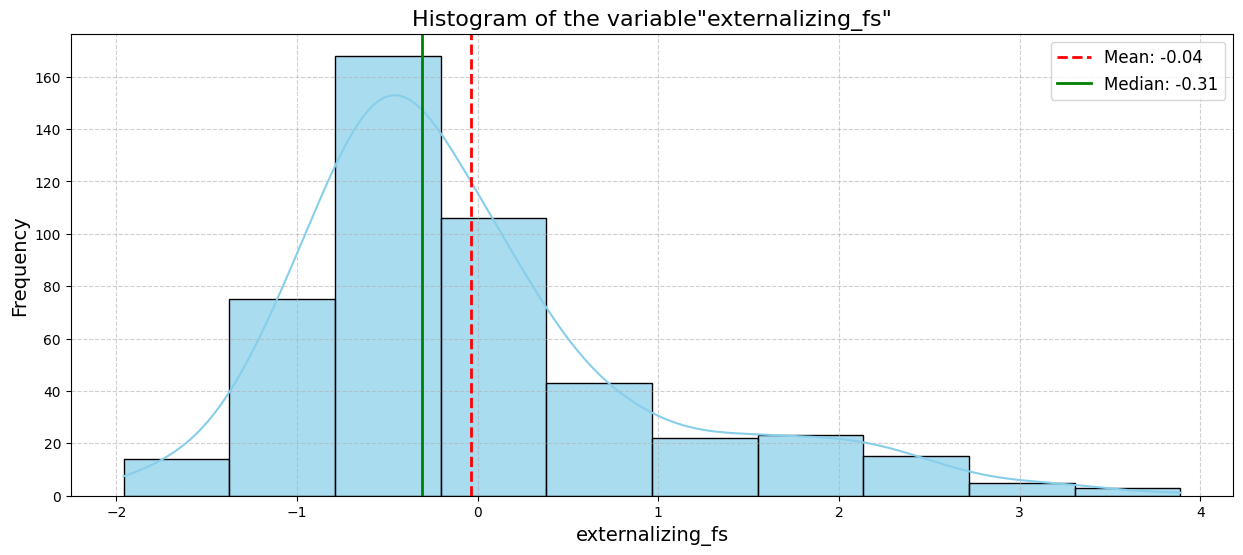

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


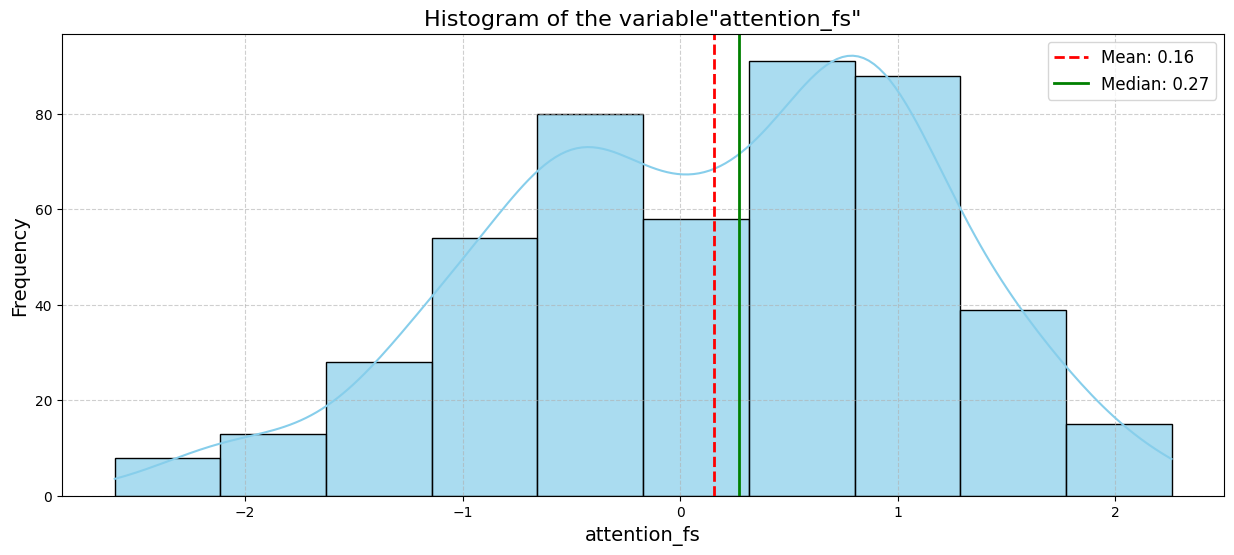

In [118]:
for col in numerical_cols:
    mean_age = test[col].mean()
    median_age = test[col].median()

    # Create the histogram with enhancements
    fig, ax = plt.subplots(figsize=(15, 6))
    sns.histplot(data=test, x=col, bins=10, kde=True, color='skyblue', edgecolor='black', alpha=0.7)
    
    # Add vertical lines for mean and median
    ax.axvline(mean_age, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_age:.2f}')
    ax.axvline(median_age, color='green', linestyle='-', linewidth=2, label=f'Median: {median_age:.2f}')

    # Add title, labels, and legend
    ax.set_title(f'Histogram of the variable"{col}"', fontsize=16)
    ax.set_xlabel(col, fontsize=14)
    ax.set_ylabel('Frequency', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)

    # Show the plot
    plt.show()

#### Acelasi lucru in cazul variabile 'bmi' si pentru setul de testare. Verificam boxplot-ul:

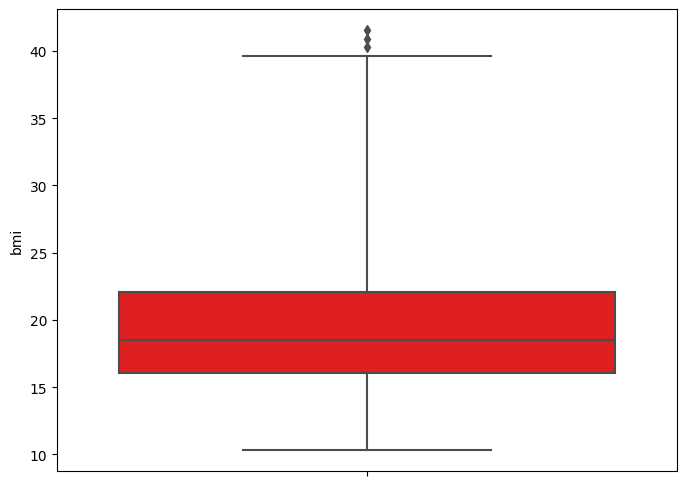

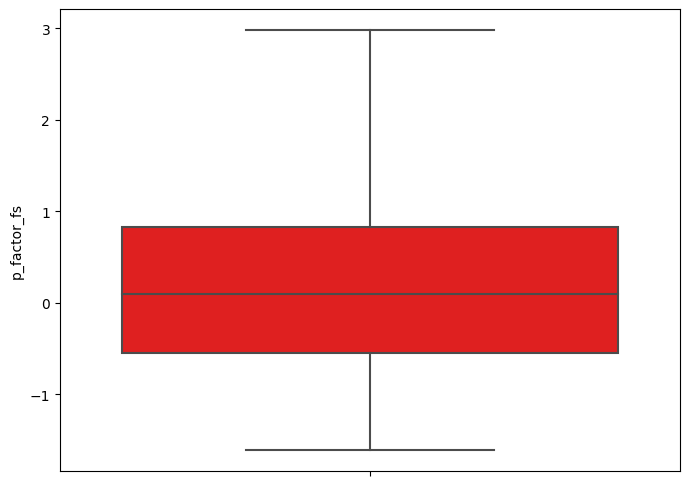

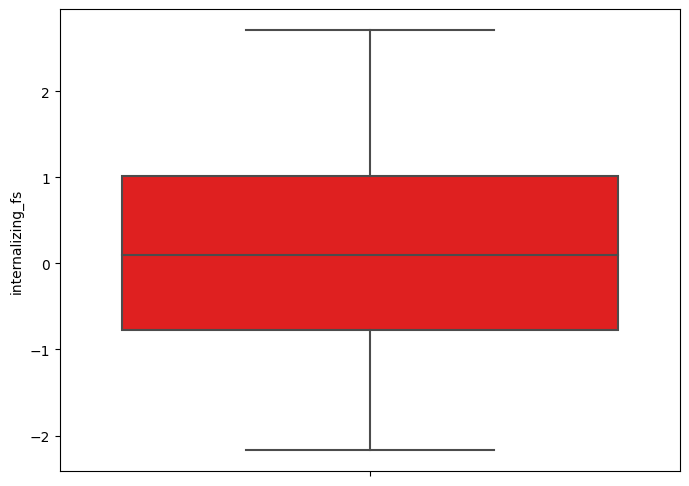

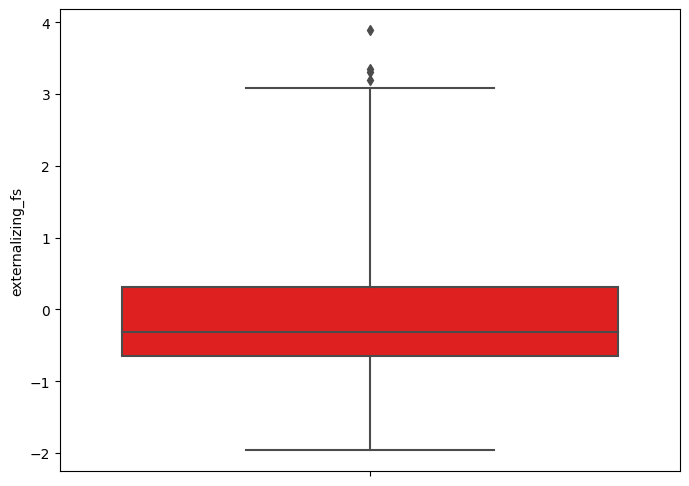

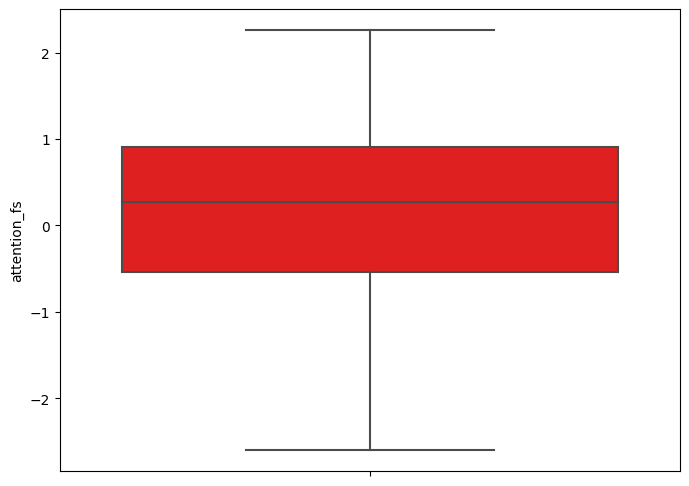

In [119]:
for col in numerical_cols:
    fig, ax = plt.subplots(figsize = (8,6))
    sns.boxplot(y = test[col], color = 'red', whis = 3)
    plt.show()

#### Reiese ca, de fapt, si variabila 'externalizing_fs' are outlieri.

## Outlier treatment

In [120]:
def outlier_treatment (dataframe, col):
    q1 = dataframe[col].quantile(0.25)
    q3 = dataframe[col].quantile(0.75)
    IQR = q3-q1
    lower_limit = q1-3*IQR
    upper_limit = q3+3*IQR
    dataframe[col] = np.where(dataframe[col] < lower_limit, lower_limit, np.where(dataframe[col] > upper_limit, upper_limit, dataframe[col]))

In [121]:
outlier_heavy_cols = ['bmi','externalizing_fs']
outlier_treatment(train,'bmi')
for i in outlier_heavy_cols:
    outlier_treatment(test,i)

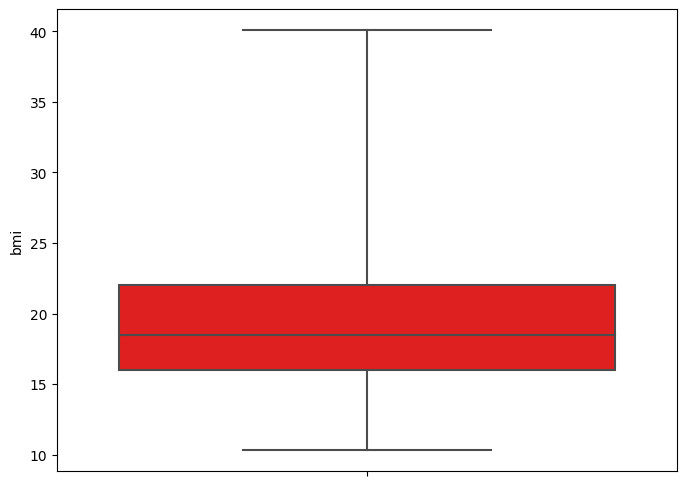

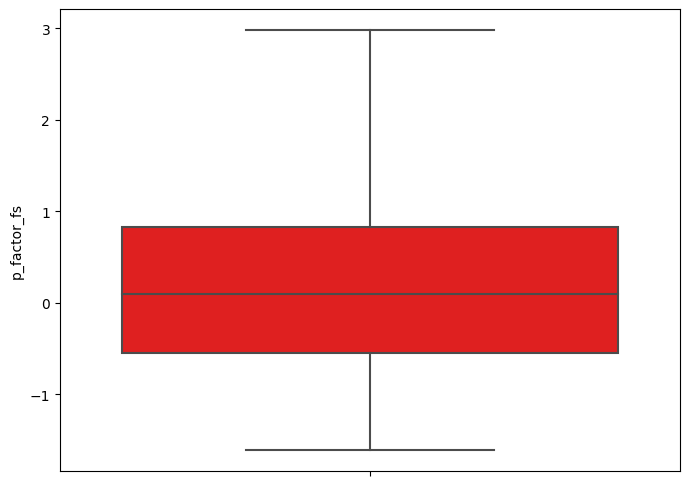

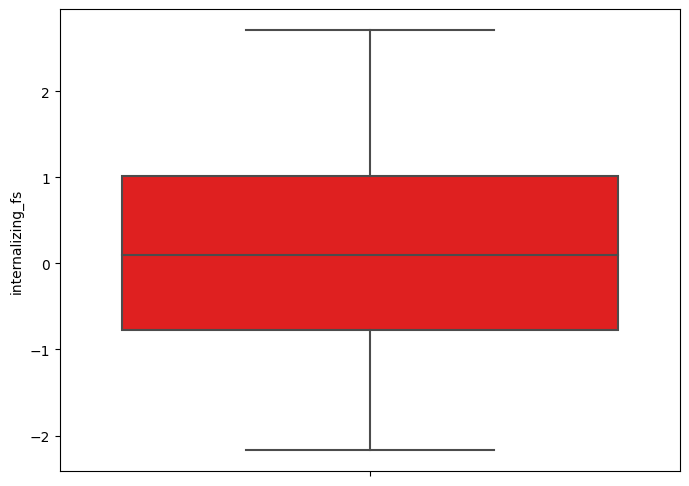

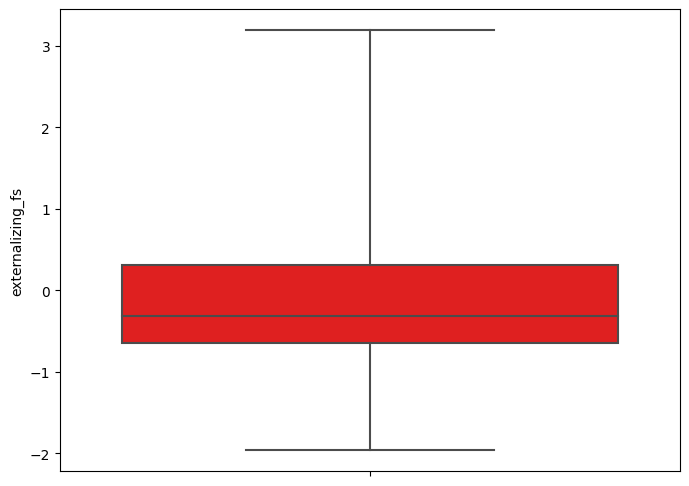

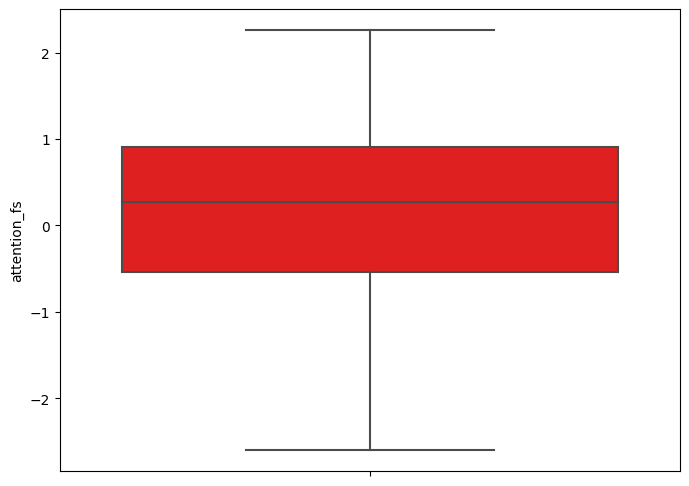

In [122]:
for col in numerical_cols:
    fig, ax = plt.subplots(figsize = (8,6))
    sns.boxplot(y = test[col], color = 'red', whis = 3)
    plt.show()

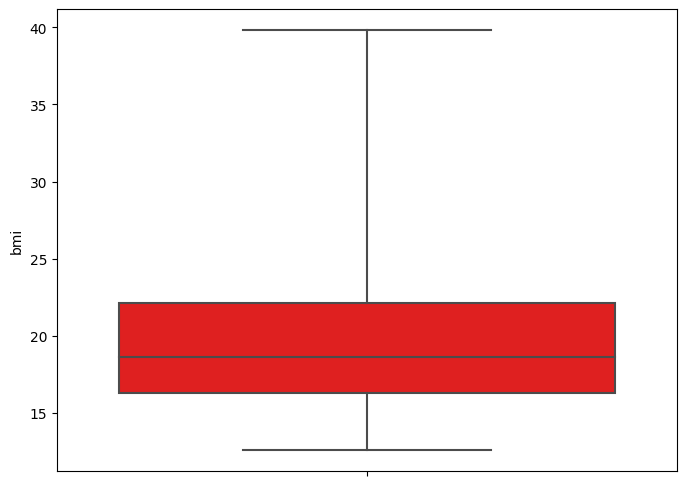

In [123]:
fig, ax = plt.subplots(figsize = (8,6))
sns.boxplot(y = train['bmi'], color = 'red', whis = 3)
plt.show()

#### Acum variabilele nu mai au outlieri.
#### In ambele seturi de date, variabilele tot nu sunt simetric distribuite, insa acest lucru va putea fi remediat ulterior, prin standardizare. 

## Correlation Analysis

### a) Train dataset

In [124]:
correlation_train = train[numerical_cols].corr()
correlation_train

,bmi,p_factor_fs,internalizing_fs,externalizing_fs,attention_fs
bmi,1.0,0.1,0.1,-0.1,-0.1
p_factor_fs,0.1,1.0,0.2,0.3,-0.1
internalizing_fs,0.1,0.2,1.0,-0.2,-0.1
externalizing_fs,-0.1,0.3,-0.2,1.0,-0.1
attention_fs,-0.1,-0.1,-0.1,-0.1,1.0


<function matplotlib.pyplot.show(close=None, block=None)>

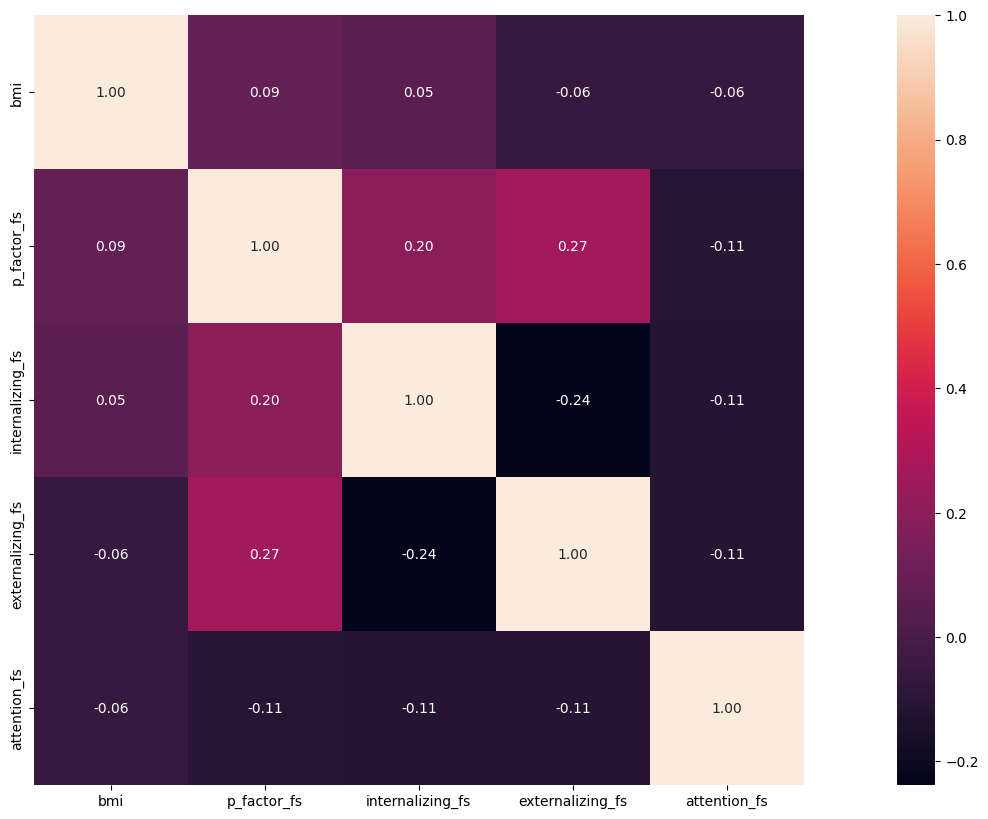

In [125]:
fig, ax = plt.subplots(figsize = (24,10))
sns.heatmap(correlation_train, annot = True, square = True, fmt = '.2f')
plt.show

#### Nu exista corelatii puternice sau medii intre variabile.

### b) Test dataset

In [126]:
correlation_test = test[numerical_cols].corr()
correlation_test

,bmi,p_factor_fs,internalizing_fs,externalizing_fs,attention_fs
bmi,1.0,0.0,0.1,-0.1,-0.1
p_factor_fs,0.0,1.0,0.2,0.2,-0.1
internalizing_fs,0.1,0.2,1.0,-0.2,-0.2
externalizing_fs,-0.1,0.2,-0.2,1.0,-0.0
attention_fs,-0.1,-0.1,-0.2,-0.0,1.0


<function matplotlib.pyplot.show(close=None, block=None)>

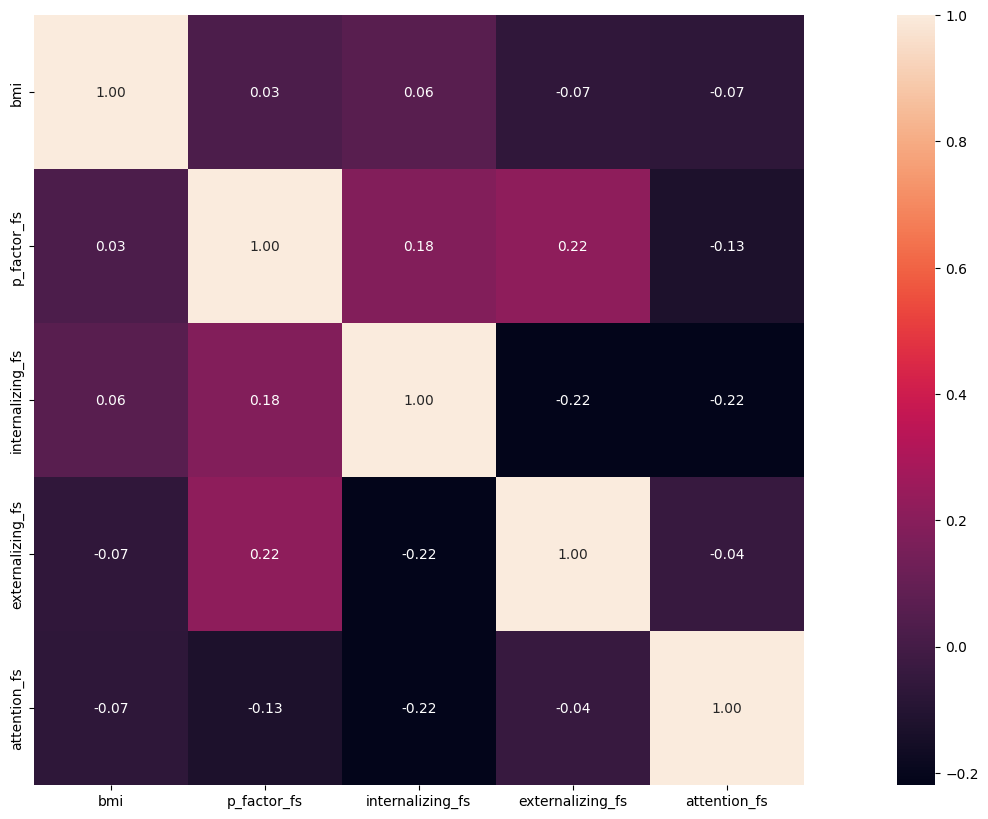

In [127]:
fig, ax = plt.subplots(figsize = (24,10))
sns.heatmap(correlation_test, annot = True, square = True, fmt = '.2f')
plt.show

#### Nici aici nu exista corelatii puternice sau medii intre variabile.
#### Asadar, oricare dintre variabile pot fi introduse in modelul de machine learning in orice combinatie, fara a exista riscul de a aparea fenomenul de multicoliniaritate a variabilelor inependente.

### Scatterplots

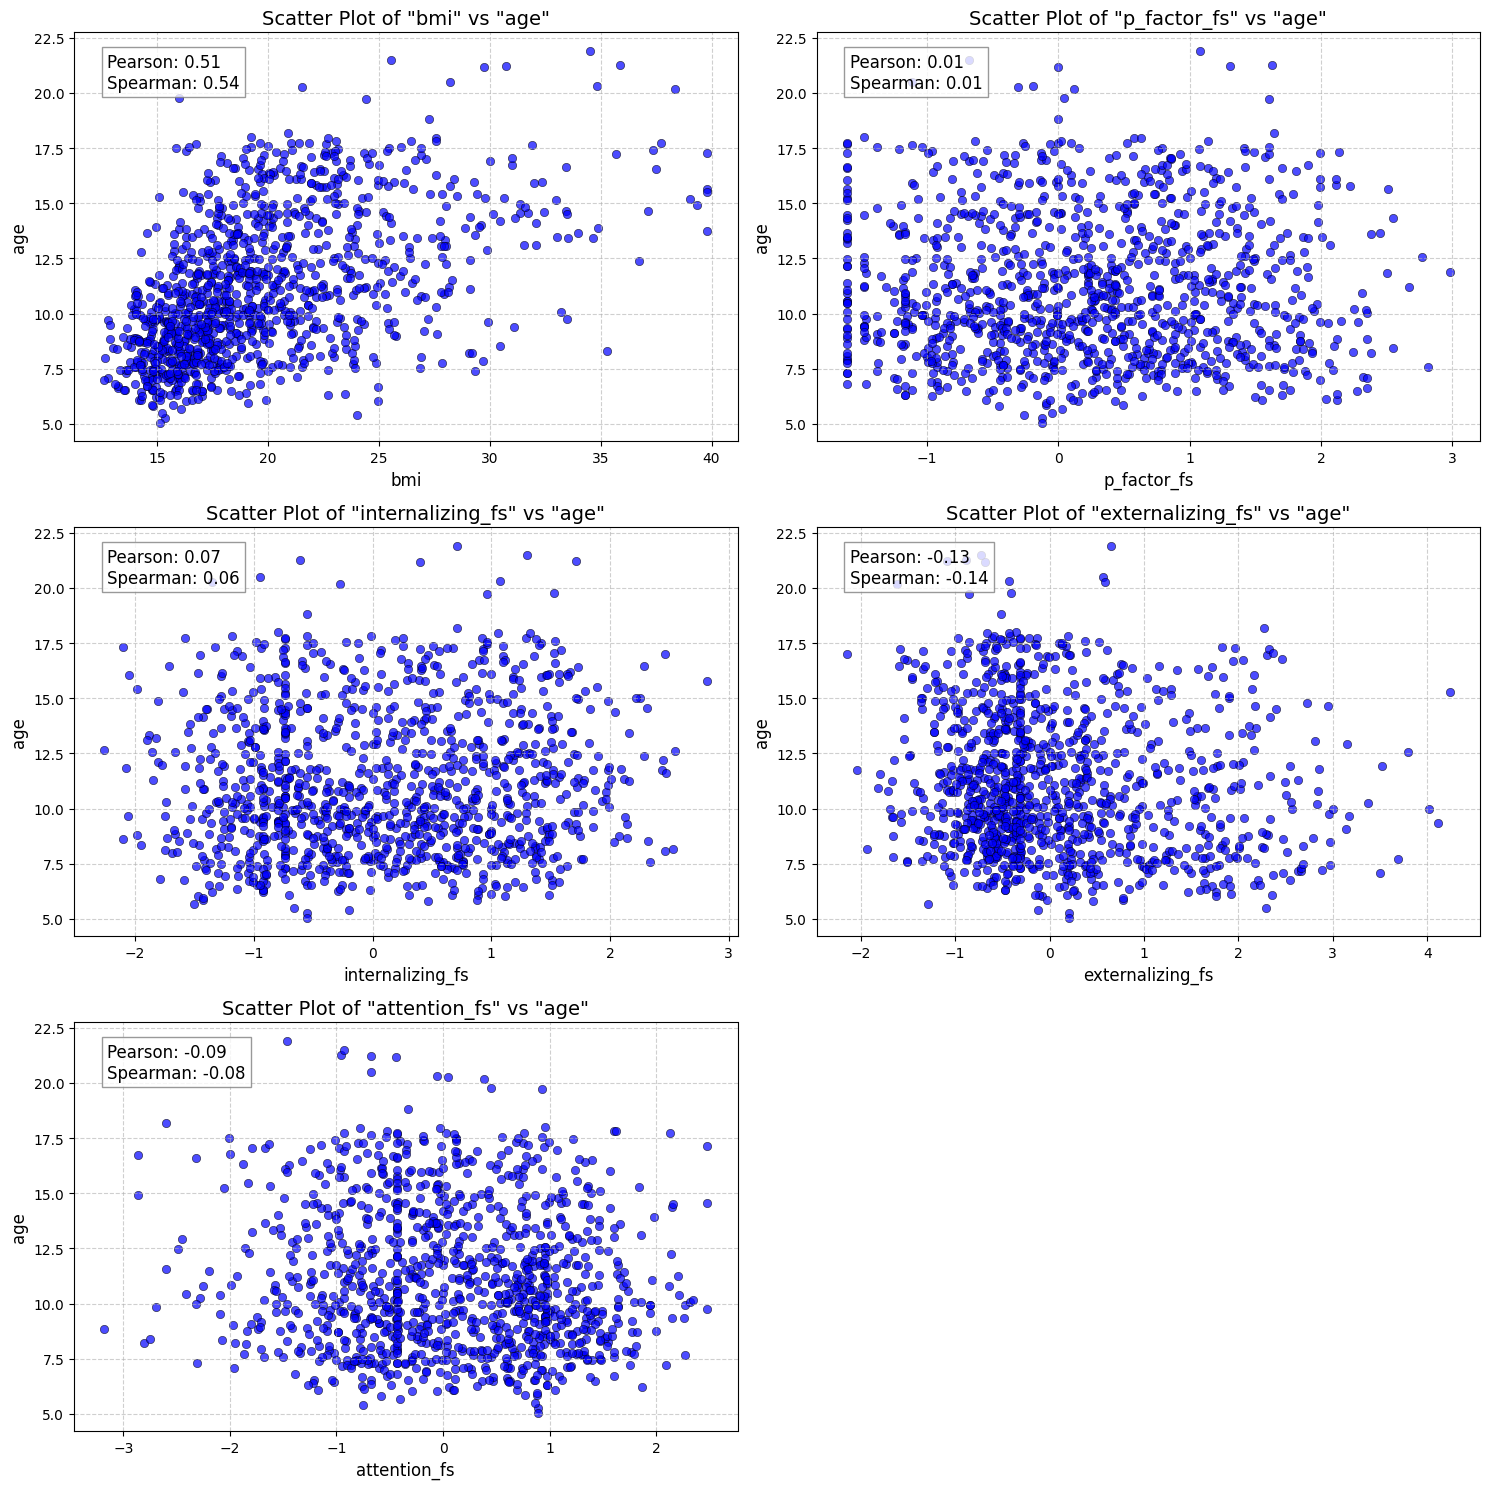

In [130]:
from scipy.stats import pearsonr, spearmanr

# Define the number of columns for the subplot grid
n_cols = 2  # Number of columns in the grid
n_rows = -(-len(numerical_cols) // n_cols)  # Calculate rows (ceil division)

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))  # Adjust figure size for readability
axes = axes.flatten()  # Flatten the axes array for easier indexing

# Iterate over numerical columns and plot scatter plots with correlation coefficients
for i, col in enumerate(numerical_cols):
    # Calculate Pearson and Spearman correlations
    pearson_corr, _ = pearsonr(train[col], train['age'])
    spearman_corr, _ = spearmanr(train[col], train['age'])
    
    # Plot scatter plot
    sns.scatterplot(data=train, x=col, y='age', ax=axes[i], color='blue', alpha=0.7, edgecolor='black')
    axes[i].set_title(f'Scatter Plot of "{col}" vs "age"', fontsize=14)
    axes[i].set_xlabel(col, fontsize=12)
    axes[i].set_ylabel('age', fontsize=12)
    axes[i].grid(True, linestyle='--', alpha=0.6)
    
    # Add correlation coefficients as text annotation
    axes[i].text(
        0.05, 0.95,  # Coordinates in the axes (relative, from 0 to 1)
        f"Pearson: {pearson_corr:.2f}\nSpearman: {spearman_corr:.2f}",
        fontsize=12,
        ha='left', va='top',
        transform=axes[i].transAxes,  # Use relative positioning
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray')
    )

# Hide unused subplots if the grid has extra spaces
for j in range(len(numerical_cols), len(axes)):
    axes[j].set_visible(False)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


#### Singura legatura cat de cat puternica este cea dintre 'age' si 'bmi'

In [143]:
dummies = pd.get_dummies(train[categorical_cols])
dummies

,sex_Female,sex_Male,study_site_HBNsiteCBIC,study_site_HBNsiteCUNY,study_site_HBNsiteRU,study_site_HBNsiteSI,ethnicity_Hispanic_or_Latino,ethnicity_Not_Hispanic_or_Latino,ethnicity_Unknown,race_Asian,...,parent_1_education_Complete_primary,parent_1_education_Complete_secondary,parent_1_education_Complete_tertiary,parent_1_education_No_incomplete primary,parent_1_education_Unknown,parent_2_education_Complete_primary,parent_2_education_Complete_secondary,parent_2_education_Complete_tertiary,parent_2_education_No_incomplete primary,parent_2_education_Unknown
0,True,False,False,False,True,False,False,True,False,False,...,False,False,True,False,False,False,False,True,False,False
1,False,True,False,False,True,False,False,True,False,False,...,False,True,False,False,False,False,False,False,True,False
2,True,False,False,False,True,False,False,True,False,False,...,False,False,True,False,False,False,False,True,False,False
3,True,False,False,False,False,True,True,False,False,False,...,True,False,False,False,False,False,True,False,False,False
4,False,True,True,False,False,False,False,False,True,False,...,False,False,True,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099,True,False,True,False,False,False,True,False,False,False,...,False,False,True,False,False,False,True,False,False,False
1100,False,True,True,False,False,False,False,True,False,False,...,False,False,True,False,False,False,False,True,False,False
1101,False,True,True,False,False,False,True,False,False,False,...,False,False,True,False,False,False,False,True,False,False
1102,False,True,False,False,True,False,False,True,False,False,...,False,True,False,False,False,False,True,False,False,False


In [147]:
y = train['age'].astype(float)  # Continuous variable
dummies = pd.get_dummies(train[categorical_cols])  # One-hot encode categorical columns

# List to store results as (column, correlation) tuples
results = []

# Loop through dummy columns to calculate point biserial correlation
for column in dummies.columns:
    x = dummies[column]  # Get the binary values for the dummy column
    corr, p_value = stats.pointbiserialr(x, y)  # Calculate correlation
    results.append((column, corr))  # Append column name and correlation

# Sort results by correlation in descending order
sorted_results = sorted(results, key=lambda x: x[1], reverse=True)

# Print sorted results
for column, corr in sorted_results:
    print(f"{column}: {corr:.4f}")



parent_1_education_No_incomplete primary: 0.0804
ethnicity_Unknown: 0.0775
parent_2_education_Complete_primary: 0.0631
handedness_Right: 0.0498
study_site_HBNsiteCBIC: 0.0488
race_Unknown: 0.0485
parent_2_education_Unknown: 0.0484
sex_Female: 0.0392
race_Black: 0.0267
parent_1_education_Unknown: 0.0263
study_site_HBNsiteSI: 0.0209
race_Other: 0.0185
parent_2_education_No_incomplete primary: 0.0072
parent_1_education_Complete_secondary: 0.0030
parent_1_education_Complete_primary: -0.0022
parent_2_education_Complete_secondary: -0.0038
handedness_Ambidextrous: -0.0161
race_Asian: -0.0171
ethnicity_Not_Hispanic_or_Latino: -0.0245
ethnicity_Hispanic_or_Latino: -0.0261
sex_Male: -0.0392
study_site_HBNsiteCUNY: -0.0393
parent_1_education_Complete_tertiary: -0.0414
handedness_Left: -0.0464
study_site_HBNsiteRU: -0.0510
parent_2_education_Complete_tertiary: -0.0574
race_White: -0.0618


<ipython-input-147-e5da5f99d3c0>:10: DeprecationWarning: Please import `pointbiserialr` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  corr, p_value = stats.pointbiserialr(x, y)  # Calculate correlation


#### Si de aici reiese ca doar variabila '

### Acum, datele sunt pregatite pentru a estima modele de machine learning!

# Directii de imbunatatire viitoare pentru concurs

#### O posibila directie de imbunatatire pentru a creste calitatea modelelor ar fi sa aplicam metoda "One Hot Encoder" pentru variabilele categoriale.

# Machine Learning

#### Cream variabile X si y pentru variabilele explicative, respectiv cea dependenta:

In [ ]:
X = train['']

## Train test split

In [156]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

NameError: name 'X' is not defined